In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(540, 540, 3)


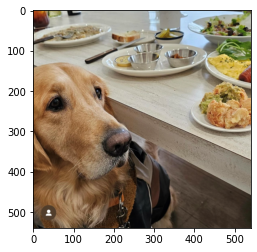

In [3]:
# 이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dogbig.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape) # 이미지 크기 확인

# 불러온 이미지 확인
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(사진출처 : 인스타그램 "life_of_duckoo")

#### PixelLib의 pascalvoc 새그맨테이션 함수 동물도 잘 인식한다고 하여서 그대로 사용

In [4]:
# 모델 가져오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드 시작
urllib.request.urlretrieve(model_url, model_file) 
# urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7feb41baf820>)

#### 모델 생성

In [8]:
 #PixelLib 클래스를 가져와서 semantic segmentation 인스턴스를 만듬
model = semantic_segmentation()

# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file) 

- segmentAsPascalvoc()함수를 호출 하여 입력된 이미지의 "분할, 분할 출력의 배열"을 가져옴
- 분할, pacalvoc 데이터로 학습된 모델을 이용하여 진행됨

In [15]:
segvalues, output = model.segmentAsPascalvoc(img_path) 

In [16]:
# pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

#### 함수`segmentAsPascalvoc()`호출하여 얻는 결과값(segvalues, output)확인. 

In [17]:
# segvalues중 인스턴스로 인식된 것 확인 (class_ids)
print(segvalues)

{'class_ids': array([ 0,  5, 11, 12]), 'masks': array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])}


In [18]:
# segvalues중 인스턴스로 인식된 것 확인 (영문명)
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
diningtable
dog


- Output 시각화하여, 인스턴스 구분 잘됐나 확인

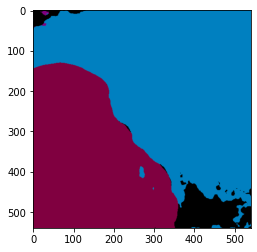

In [19]:
# segmentAsPascalvoc() 함수 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 
# output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

#### class_id 4개의 rgb를 알고자 함
 *BUT HOW?*
- 그 다음 color map에서 (LABEL_NAMES index따라 매칭됨) 인스턴스별 컬러코드 확인하기
- 배경(0), 병(5), 식탁(11), 개(12)

In [21]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

print(colormap[0])   # 배경
print(colormap[5])   # 병
print(colormap[11])  # 식탁
print(colormap[12])  # 개

[0 0 0]
[128   0 128]
[192 128   0]
[ 64   0 128]


#### Dog의 색상순서 바꿔주기 : BGR 순으로 정리된 color map을 RGB로 바꿔주기
- person ( 64   0 128)는 사실 (128, 0, 64)인것!

In [22]:
seg_color = (128,0,64) # RGB -> BGR 

(540, 540)


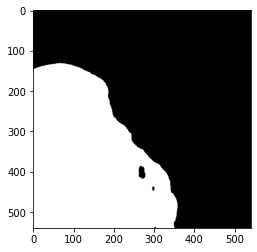

In [23]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

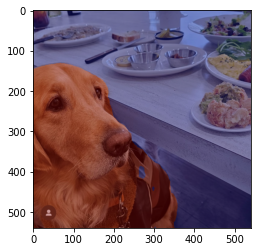

In [24]:
# 원본이미지를 img_show에 할당한뒤 이미지 dog이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 📌 배경을 흐리게 하기!

#### 흐린 배경 이미지 만들기 (1/2) :  `img_orig_blur`(배경용 이미지)를 `cv2.blur` 함수로 흐리게 한다

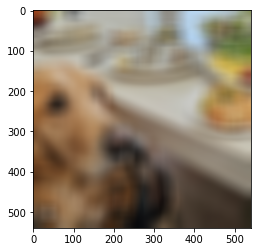

In [31]:
# (k1,k1)은 blurring kernel size를 뜻합니다
img_orig_blur = cv2.blur(img_orig, (39,39))  # (img_orig, (99,99))

# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 이미지 색상 채널 변경
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB)) # BGR 형식 -> RGB 형식   
plt.show()

#### 흐린 배경 이미지 만들기 (2/2) : 사람을 지운다

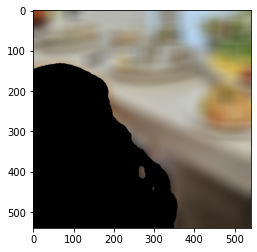

In [32]:
# Dog의 마스크 인식
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 사람사진과 배경사진을 합한다! 

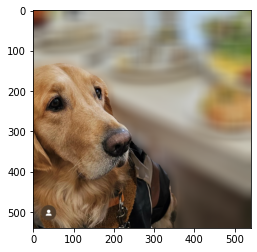

In [33]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()